In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # PathMNIST has 3 channels
])

train_ds = ImageFolder("data/train", transform=transform)
val_ds = ImageFolder("data/val", transform=transform)
test_ds = ImageFolder("data/test", transform=transform)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)
test_loader = DataLoader(test_ds, batch_size=64)

In [3]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 9)  # PathMNIST has 9 classes
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)


In [4]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [5]:
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss:.4f}, Accuracy: {100 * correct / total:.2f}%")


Epoch 1/15, Loss: 1142.7521, Accuracy: 69.69%
Epoch 2/15, Loss: 721.4211, Accuracy: 80.94%
Epoch 3/15, Loss: 581.8625, Accuracy: 84.90%
Epoch 4/15, Loss: 501.5227, Accuracy: 87.14%
Epoch 5/15, Loss: 439.0906, Accuracy: 88.69%
Epoch 6/15, Loss: 389.5280, Accuracy: 89.96%
Epoch 7/15, Loss: 355.2850, Accuracy: 90.85%
Epoch 8/15, Loss: 322.0228, Accuracy: 91.81%
Epoch 9/15, Loss: 298.9809, Accuracy: 92.29%
Epoch 10/15, Loss: 273.8687, Accuracy: 92.95%
Epoch 11/15, Loss: 261.8448, Accuracy: 93.37%
Epoch 12/15, Loss: 243.7504, Accuracy: 93.76%
Epoch 13/15, Loss: 236.5112, Accuracy: 93.94%
Epoch 14/15, Loss: 218.6366, Accuracy: 94.39%
Epoch 15/15, Loss: 210.0621, Accuracy: 94.61%


In [6]:
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

if test_total > 0:
    print('Test Accuracy: %.2f %%' % (100 * test_correct / test_total))
else:
    print("Test set appears to be empty.")


Test Accuracy: 82.45 %


In [7]:
# Save surrogate
torch.save(model.state_dict(), "surrogate_model.pth")

In [19]:
def fgsm_attack(image, epsilon, data_grad):
    # Generate adversarial examples using the sign of the gradient
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    return torch.clamp(perturbed_image, 0, 1)

def blackbox_fgsm_attack(surrogate_model, target_model, data_loader, epsilon, device):
    import torch.nn as nn
    loss_fn = nn.CrossEntropyLoss()
    correct_clean = 0
    correct_adv = 0
    adv_examples = []

    surrogate_model.eval()
    target_model.eval()

    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        images.requires_grad = True

        # Clean predictions from target model (before perturbation)
        with torch.no_grad():
            clean_outputs = target_model(images)
            clean_preds = clean_outputs.max(1)[1]
            correct_clean += clean_preds.eq(labels).sum().item()

        # Surrogate gradient
        outputs = surrogate_model(images)
        loss = loss_fn(outputs, labels)
        surrogate_model.zero_grad()
        loss.backward()
        data_grad = images.grad.data

        # Perturb
        perturbed_images = fgsm_attack(images, epsilon, data_grad)

        # Target model on adversarial examples
        with torch.no_grad():
            adv_outputs = target_model(perturbed_images)
            adv_preds = adv_outputs.max(1)[1]
            correct_adv += adv_preds.eq(labels).sum().item()

        # Collect visuals
        if len(adv_examples) < 5:
            for i in range(images.shape[0]):
                if len(adv_examples) >= 5:
                    break
                adv_examples.append((images[i].detach(), labels[i].detach(), perturbed_images[i].detach(), adv_preds[i].item()))

    total = len(data_loader.dataset)
    clean_acc = correct_clean / total
    adv_acc = correct_adv / total

    print(f"FGSM Epsilon: {epsilon:.2f}\tClean Accuracy = {clean_acc:.4f}\tAdversarial Accuracy = {adv_acc:.4f}")
    return clean_acc, adv_acc, adv_examples



FGSM Epsilon: 0.03	Clean Accuracy = 0.7917	Adversarial Accuracy = 0.2649

Running attack with epsilon = 0.001
FGSM Epsilon: 0.00	Clean Accuracy = 0.7981	Adversarial Accuracy = 0.4166
Clean Accuracy = 79.81% | Accuracy under attack (ε=0.00) = 41.66%



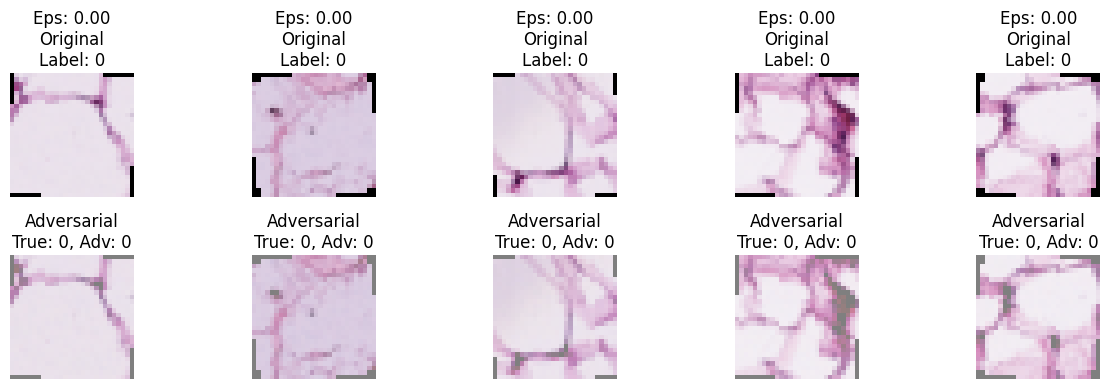


Running attack with epsilon = 0.01
FGSM Epsilon: 0.01	Clean Accuracy = 0.7949	Adversarial Accuracy = 0.3816
Clean Accuracy = 79.49% | Accuracy under attack (ε=0.01) = 38.16%



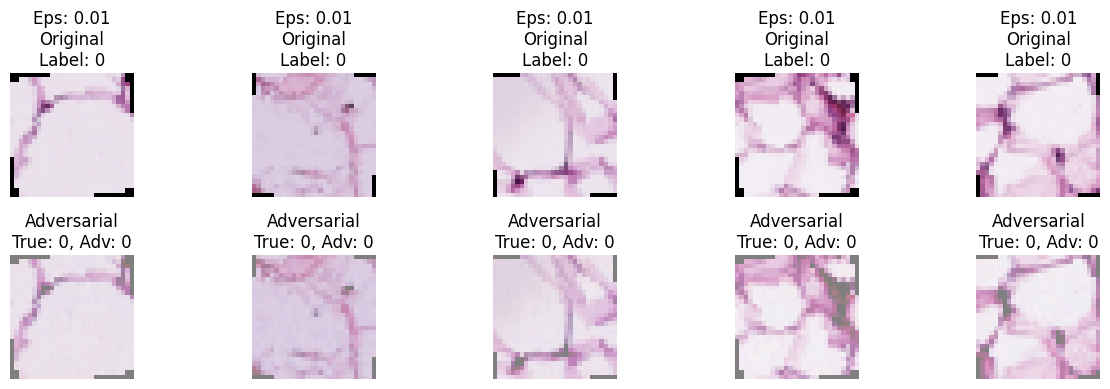


Running attack with epsilon = 0.05
FGSM Epsilon: 0.05	Clean Accuracy = 0.7938	Adversarial Accuracy = 0.1538
Clean Accuracy = 79.38% | Accuracy under attack (ε=0.05) = 15.38%



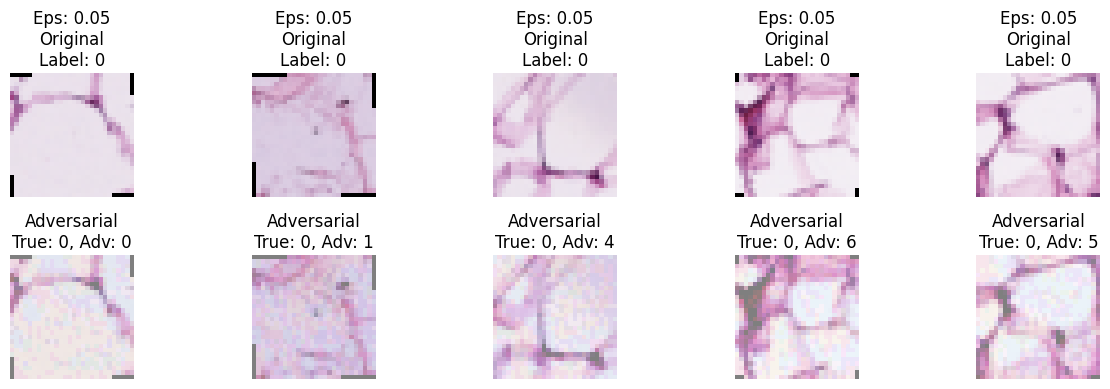


Running attack with epsilon = 0.1
FGSM Epsilon: 0.10	Clean Accuracy = 0.7921	Adversarial Accuracy = 0.0722
Clean Accuracy = 79.21% | Accuracy under attack (ε=0.10) = 7.22%



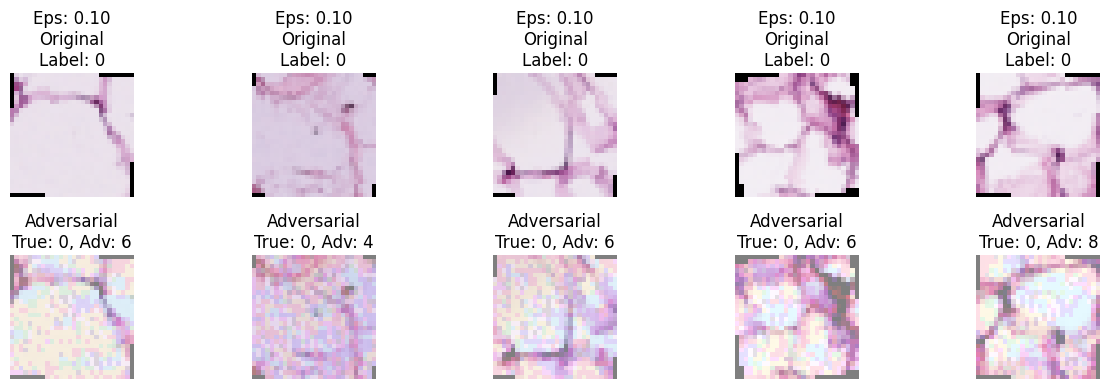


Running attack with epsilon = 0.15
FGSM Epsilon: 0.15	Clean Accuracy = 0.7924	Adversarial Accuracy = 0.0860
Clean Accuracy = 79.24% | Accuracy under attack (ε=0.15) = 8.60%



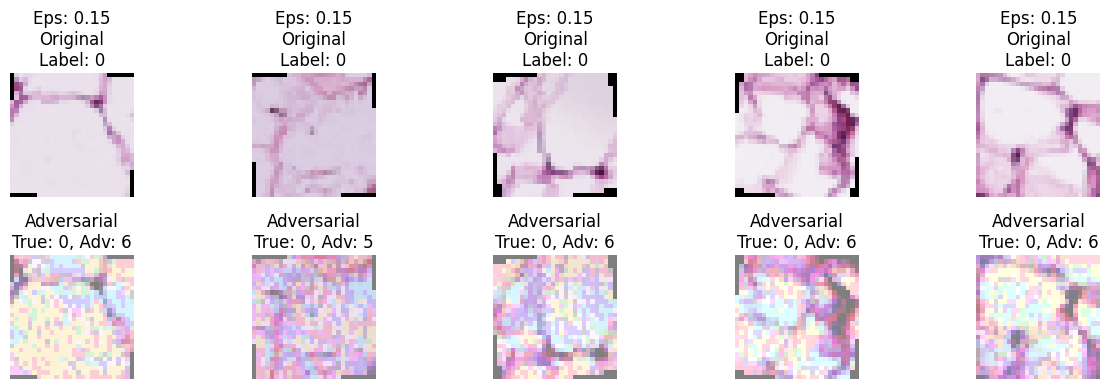

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

target_model = SimpleCNN().to(device)
surrogate_model = SimpleCNN().to(device)

target_model.load_state_dict(torch.load("model_pathmnist.pth", map_location=device))
target_model.eval()

surrogate_model.load_state_dict(torch.load("surrogate_model.pth", map_location=device))
surrogate_model.eval()

acc, adv_acc, adv_examples = blackbox_fgsm_attack(
    surrogate_model=surrogate_model,
    target_model=target_model,
    data_loader=test_loader,
    epsilon=epsilon,
    device=device
)
epsilons = [0.001, 0.01, 0.05, 0.1, 0.15]
num_examples = 5
def plot_epsilon_grid(epsilons, model_s, model_t, loader, device, num_examples=5):
    import matplotlib.pyplot as plt
    import numpy as np

    for row, eps in enumerate(epsilons):
        print(f"\nRunning attack with epsilon = {eps}")
        clean_acc, adv_acc, examples = blackbox_fgsm_attack(model_s, model_t, loader, eps, device)

        print(f"Clean Accuracy = {clean_acc:.2%} | Accuracy under attack (ε={eps:.2f}) = {adv_acc:.2%}\n")

        plt.figure(figsize=(num_examples * 2.5, 4))

        for col, (orig, label, adv, pred) in enumerate(examples):
            orig = (orig.permute(1, 2, 0).cpu().numpy() * 0.5) + 0.5
            adv = (adv.permute(1, 2, 0).cpu().numpy() * 0.5) + 0.5

            orig = np.clip(orig, 0, 1)
            adv = np.clip(adv, 0, 1)

            plt.subplot(2, num_examples, col + 1)
            plt.imshow(orig)
            plt.title(f"Eps: {eps:.2f}\nOriginal\nLabel: {label.item()}")
            plt.axis('off')

            plt.subplot(2, num_examples, col + 1 + num_examples)
            plt.imshow(adv)
            plt.title(f"Adversarial\nTrue: {label.item()}, Adv: {pred}")
            plt.axis('off')

        plt.tight_layout()
        plt.show()


# Run the grid visualization
plot_epsilon_grid(epsilons, surrogate_model, target_model, test_loader, device, num_examples)